In [1]:
import sys
sys.path.insert(0, './utils/')
from helper_functions import *
from Config import Config

import glob
import time

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from moviepy.editor import VideoFileClip

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

seed = 0

# Load images and visualize:

In [2]:
cars = glob.glob('./dataset/vehicles/**/*.png')
num_car_image = len(cars)

notcars = glob.glob('./dataset/non-vehicles/**/*.png')
num_not_car_image = len(notcars)

print('# car images:', num_car_image, '\n# non-car images:', num_not_car_image)

# car images: 8792 
# non-car images: 8968


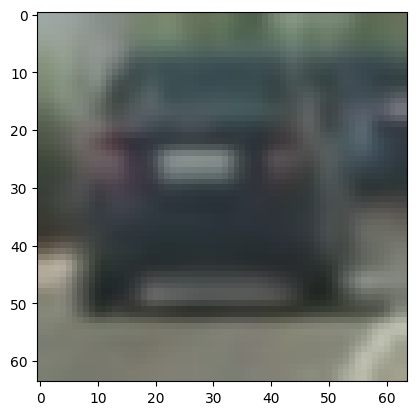

In [3]:
image_test1 = np.asarray(Image.open(cars[0]))
plt.imshow(image_test1)

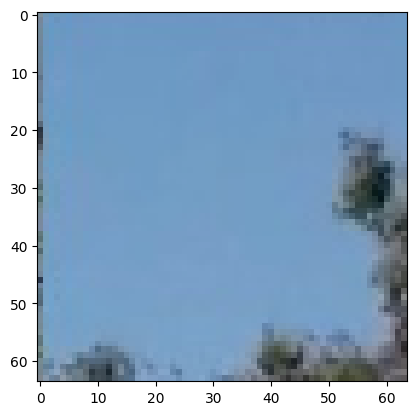

In [4]:
image_test2 = np.asarray(Image.open(notcars[0]))
plt.imshow(image_test2)

In [5]:
for i in range(len(cars)):
    cars[i] = np.asarray(Image.open(cars[i]))

for i in range(len(notcars)):
    notcars[i] = np.asarray(Image.open(notcars[i]))

# Training the Model:

In [6]:
car_features = extract_features(cars, 
                                Config.color_space, Config.spatial_size, 
                                Config.hist_bins, Config.orient,
                                Config.pix_per_cell, Config.cell_per_block,
                                Config.hog_channel, Config.spatial_feat,
                                Config.hist_feat, Config.hog_feat)

notcar_features = extract_features(notcars,
                                   Config.color_space, Config.spatial_size,
                                   Config.hist_bins, Config.orient,
                                   Config.pix_per_cell, Config.cell_per_block,
                                   Config.hog_channel, Config.spatial_feat,
                                   Config.hist_feat, Config.hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64) 

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

    
print('Feature vector length:', len(X_train[0]))

Feature vector length: 6108


In [22]:
# gs_svc = LinearSVC()
import xgboost as xgb
model = xgb.XGBClassifier()

model.fit(X_train, y_train)

print('Test Accuracy of Model = ', round(model.score(X_test, y_test), 4))

Test Accuracy of Model =  0.9961


In [23]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1829
         1.0       1.00      0.99      1.00      1723

    accuracy                           1.00      3552
   macro avg       1.00      1.00      1.00      3552
weighted avg       1.00      1.00      1.00      3552



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Visualize the distribution of feature values
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(X_train[:, 0], bins=30, kde=False, ax=ax)
ax.set_title('Distribution of Feature 1')
ax.set_xlabel('Feature Value')
ax.set_ylabel('Frequency')

X_train_df = pd.DataFrame(X_train, columns=[f'Feature {i+1}' for i in range(X_train.shape[1])])

# Visualize the correlation between features
plt.figure(figsize=(12, 8))
sns.heatmap(X_train_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

In [ ]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Visualize the distribution of feature values
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(X_train[:, 0], bins=30, kde=False, ax=ax)
ax.set_title('Distribution of Feature 1')
ax.set_xlabel('Feature Value')
ax.set_ylabel('Frequency')

X_train_df = pd.DataFrame(X_train, columns=[f'Feature {i+1}' for i in range(X_train.shape[1])])

# Visualize the correlation between features
plt.figure(figsize=(12, 8))
sns.heatmap(X_train_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

# Visualize the feature importances for the trained model
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [f'Feature {i+1}' for i in indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importances')
    plt.tight_layout()

# Visualize the decision tree if using a tree-based model
if isinstance(model, DecisionTreeClassifier):
    from sklearn.tree import export_graphviz
    import graphviz
    
    dot_data = export_graphviz(model, out_file=None, 
                               feature_names=[f'Feature {i+1}' for i in range(X_train.shape[1])],
                               filled=True, rounded=True)
    graph = graphviz.Source(dot_data)
    graph.render("decision_tree", view=True)

# Test on one image

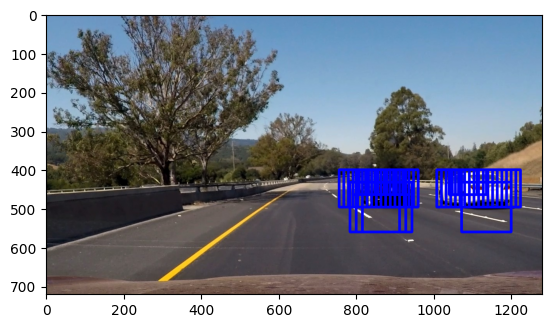

In [24]:
img = np.asarray(Image.open('./dataset/test_images/test6.jpg'))

out_img, box_list = find_cars(img, model, X_scaler, Config.y_start_stops, Config.scales, Config.window,
                              Config.color_space, Config.spatial_size,
                              Config.hist_bins, Config.orient,
                              Config.pix_per_cell, Config.cell_per_block,
                              Config.hog_channel, Config.spatial_feat,
                              Config.hist_feat, Config.hog_feat)

plt.imshow(out_img)

# Main Pipeline

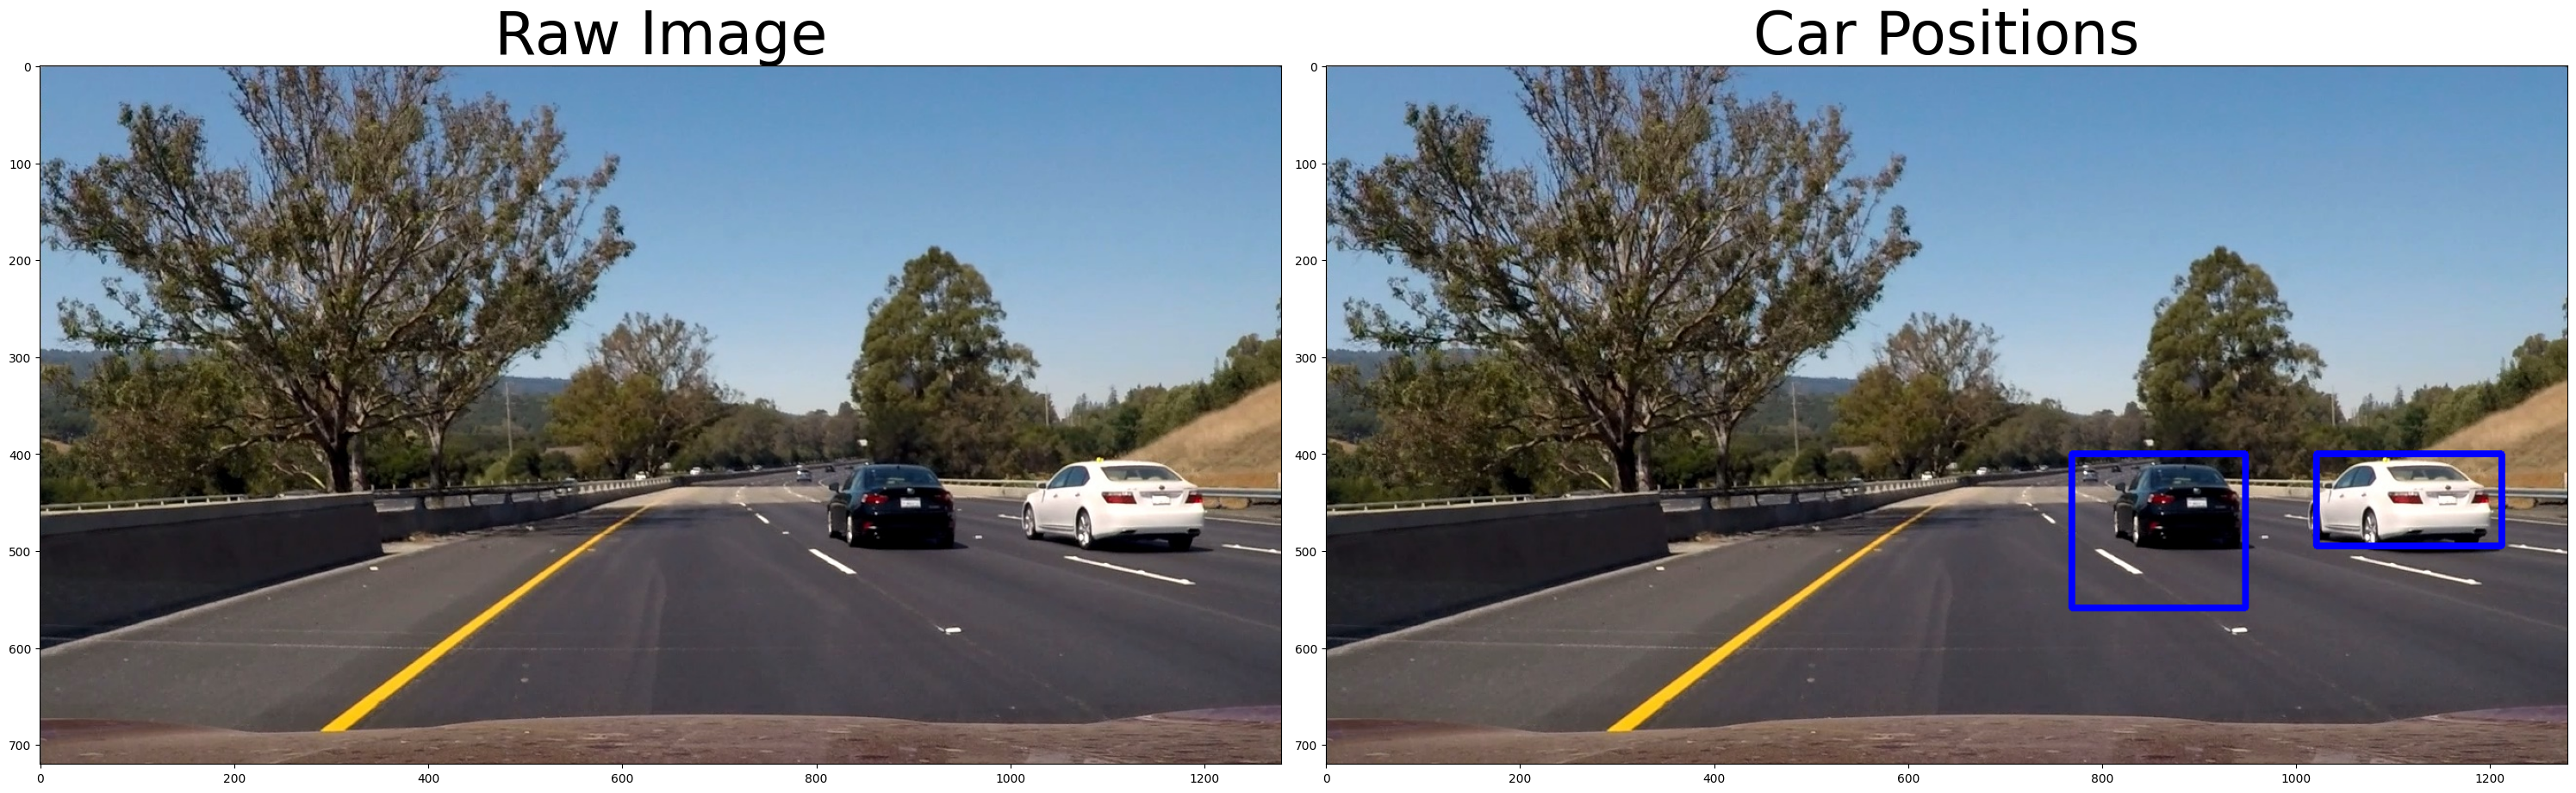

In [26]:
def main_pipeline(img):
    out_img, box_list = find_cars(img, model, X_scaler, Config.y_start_stops, Config.scales, Config.window,
                              Config.color_space, Config.spatial_size,
                              Config.hist_bins, Config.orient,
                              Config.pix_per_cell, Config.cell_per_block,
                              Config.hog_channel, Config.spatial_feat,
                              Config.hist_feat, Config.hog_feat)
    
    heatmap = np.zeros_like(img[:,:,0]).astype(float)
    heatmap = add_heat(heatmap, box_list)
    heatmap = apply_threshold(heatmap, 2)

    # Find final boxes from heatmap using label function
    labels = label(heatmap, return_num=True)
    draw_img = draw_labeled_bboxes(img, labels)
    return draw_img

image = np.asarray(Image.open('./dataset/test_images/test6.jpg'))
draw_img = main_pipeline(image)

fig = plt.figure(figsize=(30,20))
plt.subplot(121)
plt.imshow(image)
plt.title('Raw Image', {'fontsize': 50})
plt.subplot(122)
plt.imshow(draw_img)
plt.title('Car Positions', {'fontsize': 50})
fig.tight_layout()

# Test on video

In [27]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,20)
white_clip = clip1.fl_image(main_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: total: 5h 23min 37s
Wall time: 22min 51s
